In [57]:
import numpy as np 
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Layer, Lambda, InputLayer
from tensorflow.keras.metrics import mean_squared_error as mse 
from tensorflow.keras import Model
from tensorflow.keras.losses import MeanSquaredError, MeanAbsolutePercentageError
import csv
import matplotlib.pyplot as plt 
# fname = "./data/train_two_l50_j5_n15000_r0.csv"
# data = np.genfromtxt(fname, delimiter=',', skip_header=2000)
data = np.genfromtxt('./data/augment_p4.csv', delimiter=',')
test_data = np.genfromtxt('./data/test_data.csv', delimiter=',')
np.random.shuffle(data)
print(data.shape)
X = data[:, :-1]
y = data[:, -1]
X_test = test_data[:, :-1]
y_test = test_data[:, -1]
y_test = np.reshape(y_test, (1000, 1))
feature_vec_length = X.shape[1] - 1
max_num_nodes = 2**8
def split_data(data):
    x = data
    x_student = x[:, :feature_vec_length]
    temp = tf.reshape(x[:, feature_vec_length], [-1, 1])
    x_teacher = tf.concat([x[:, :feature_vec_length-1], temp], 1)
    print(f"Student={x_student}, Teacher={x_teacher}")
    return x_student, x_teacher

(52585, 54)


In [58]:
def student_info(feature_vec):
    # returns a student input vec
    bm = feature_vec[:, :-2]
    bm *= max_num_nodes/(bm.shape[1])
    bm = tf.where(bm>1, 1.0, bm/2)
    bm = tf.concat([bm, feature_vec[:, -2:]], -1)
    return bm

In [59]:
class Distiller(Model):
    def __init__(self, student, teacher):
        super().__init__()
        self.teacher = teacher
        self.student = student

    def compile(
        self,
        optimizer,
        student_loss_fn,
        distillation_loss_fn,
        alpha=0.1,
        temperature=1,
    ):
        """ Configure the distiller.

        Args:
            optimizer: Keras optimizer for the student weights
            metrics: Keras metrics for evaluation
            student_loss_fn: Loss function of difference between student
                predictions and ground-truth
            distillation_loss_fn: Loss function of difference between soft
                student predictions and soft teacher predictions
            alpha: weight to student_loss_fn and 1-alpha to distillation_loss_fn
            temperature: Temperature for softening probability distributions.
                Larger temperature gives softer distributions.
        """
        super().compile(optimizer=optimizer)
        self.student_loss_fn = student_loss_fn
        self.distillation_loss_fn = distillation_loss_fn
        self.alpha = alpha
        self.temperature = temperature

    def train_step(self, data):
        # Unpack data
        x, y = data
        x_student, x_teacher = split_data(x)
        # Forward pass of teacher
        teacher_predictions = self.teacher(x_teacher, training=False)

        with tf.GradientTape() as tape:
            # Forward pass of student
            student_predictions = self.student(x_student, training=True)

            # Compute losses
            student_loss = self.student_loss_fn(y, student_predictions)

            # Compute scaled distillation loss from https://arxiv.org/abs/1503.02531
            # The magnitudes of the gradients produced by the soft targets scale
            # as 1/T^2, multiply them by T^2 when using both hard and soft targets.
            distillation_loss = self.distillation_loss_fn(teacher_predictions,student_predictions)
            loss = self.alpha * student_loss + (1 - self.alpha) * distillation_loss

        # Compute gradients
        trainable_vars = self.student.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)

        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        # Update the metrics configured in `compile()`.
        self.compiled_metrics.update_state(y, student_predictions)

        # Return a dict of performance
        results = {m.name: m.result() for m in self.metrics}
        results.update(
            {"student_loss": student_loss, "distillation_loss": distillation_loss}
        )
        return results

    def test_step(self, data):
        # Unpack the data
        x, y = data
        x_student, x_teacher = split_data(x)    
        # Compute predictions
        y_prediction = self.student(x_student, training=False)

        # Calculate the loss
        student_loss = self.student_loss_fn(y, y_prediction)

        # Update the metrics.
        self.compiled_metrics.update_state(y, y_prediction)

        # Return a dict of performance
        results = {m.name: m.result() for m in self.metrics}
        results.update({"student_loss": student_loss})
        return results
    
    def predict_step(self, data):
        x_student, x_teacher = split_data(data)
        return ({"student_prediction": self.student(x_student, training=False)})

In [132]:
student = Sequential()
student.add(InputLayer(input_shape=(feature_vec_length, )))
student.add(Lambda(student_info, output_shape = (feature_vec_length, )))
student.add(Dense(feature_vec_length, input_shape=(feature_vec_length, ), activation='relu'))
student.add(Dense(int(feature_vec_length*(0.5)), activation='sigmoid'))
student.add(Dense(int(feature_vec_length*(0.5)), activation='sigmoid'))
student.add(Dense(1, activation='linear'))
alpha=0.6

In [133]:
teacher = load_model(f"./models/model_two_l50_j5_n50000_r0")
print(f"Loaded ./models/model_two_l50_j5_n50000_r0 as teacher")
for layer in teacher.layers:
    layer.trainable = False

Loaded ./models/model_two_l50_j5_n50000_r0 as teacher


In [134]:
learning_rate = 1e-3
momentum = 0
sgd_opt = tf.keras.optimizers.SGD(
    learning_rate=learning_rate,
    momentum = momentum
)
adam_opt = tf.keras.optimizers.Adam(
    learning_rate=learning_rate
)
distiller = Distiller(student=student, teacher=teacher)
distiller.compile(
    optimizer=adam_opt,    
    student_loss_fn=MeanSquaredError(),
    distillation_loss_fn=MeanSquaredError(),
    alpha=alpha,
    temperature=1,
)
history = distiller.fit(X, y, validation_data=(X_test, y_test), epochs = 200, batch_size = 64, shuffle=True)

Epoch 1/200
Student=Tensor("strided_slice:0", shape=(None, 52), dtype=float32), Teacher=Tensor("concat:0", shape=(None, 52), dtype=float32)
Student=Tensor("strided_slice:0", shape=(None, 52), dtype=float32), Teacher=Tensor("concat:0", shape=(None, 52), dtype=float32)
822/822 [==============================] - 5s 3ms/step - student_loss: 0.0261 - distillation_loss: 0.0173 - val_student_loss: 0.0126
Epoch 2/200
822/822 [==============================] - 2s 3ms/step - student_loss: 0.0235 - distillation_loss: 0.0109 - val_student_loss: 0.0073
Epoch 3/200
822/822 [==============================] - 2s 3ms/step - student_loss: 0.0234 - distillation_loss: 0.0101 - val_student_loss: 0.0074
Epoch 4/200
822/822 [==============================] - 2s 3ms/step - student_loss: 0.0229 - distillation_loss: 0.0091 - val_student_loss: 0.0038
Epoch 5/200
822/822 [==============================] - 2s 3ms/step - student_loss: 0.0223 - distillation_loss: 0.0084 - val_student_loss: 0.0036
Epoch 6/200
822/822

In [126]:
trained_student = distiller.student
trained_student.save("./models/student_alpha8")

INFO:tensorflow:Assets written to: ./models/student_alpha8/assets


Median test loss = 0.0025865737115964293
Median training loss = 0.020201778039336205


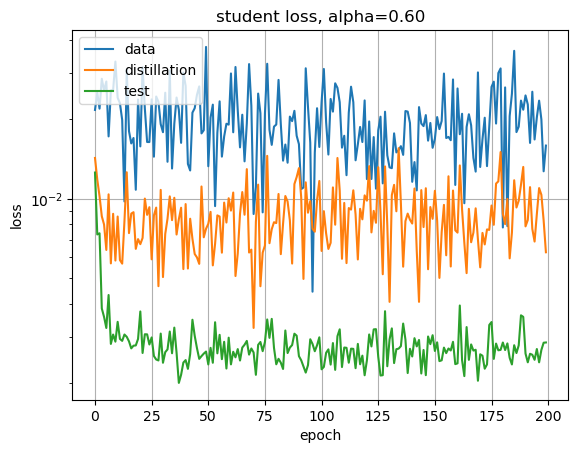

In [135]:
plt.plot(history.history['student_loss'])
plt.plot(history.history['distillation_loss'])
plt.plot(history.history['val_student_loss'])
plt.yscale('log')
plt.grid()
# plt.set_yscale('log')
plt.title(f'student loss, alpha={alpha:.2f}')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['data','distillation','test'], loc='upper left')
plt.savefig("./plots/train_student_loss_adam_alpha10.png")
print(f"Median test loss = {np.median(history.history['val_student_loss'][-10:])}")
print(f"Median training loss = {np.median(history.history['student_loss'][-10:])}")